In [1]:
import os

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
import pandas as pd
import seaborn as sns

# Is there a better way to make sure projet dir is correct?
if not set(["notebooks", "src"]).issubset(os.listdir()):
    os.chdir(os.path.dirname(os.getcwd()))

In [2]:
all_sheets = pd.read_excel(
    "data/raw/Coop_June7.xlsx",
    skiprows=0,
    parse_dates=["Date Goes Live"],
    # date_format="%m/%d/%Y %I:%M %p",
    header=1,
    sheet_name=None,
)

df_coop = pd.DataFrame()
for _, df in all_sheets.items():
    df_coop = pd.concat([df_coop, df])

del all_sheets

In [6]:
df_coop.columns

Index(['Job ID', 'Organization Name', 'Position', 'Date Goes Live',
       'Job Description', 'Program'],
      dtype='object')

In [7]:
df_coop.shape

(350802, 6)

In [8]:
df_coop = df_coop.rename(
    columns={
        "Job ID": "job_id",
        "Organization Name": "job_organization",
        "Position": "job_position",
        "Date Goes Live": "date_goes_live",
        "Job Description": "job_description",
        "Program": "program_name",
    }
)

In [9]:
df_coop.drop("job_organization", axis=1, inplace=True)

In [10]:
df_coop = df_coop.convert_dtypes(infer_objects=True)

In [11]:
df_coop.dtypes

job_id                      Int64
job_position               string
date_goes_live     datetime64[ns]
job_description            string
program_name               string
dtype: object

In [12]:
df_coop = df_coop.sort_values(["job_id"], ascending=True)

In [13]:
df_coop.date_goes_live.sort_values().min()

Timestamp('2012-08-15 11:24:00')

In [14]:
df_coop.date_goes_live.sort_values().max()

Timestamp('2023-06-07 23:59:00')

In [15]:
df_coop["job_position"].str.contains("campus bulletin", case=False).count()

350779

In [16]:
df_coop.shape

(350802, 5)

In [17]:
df_coop = df_coop[~df_coop["job_position"].str.contains("campus bulletin", case=False)]

In [18]:
df_coop.shape

(332649, 5)

In [19]:
df_coop.isnull().sum()

job_id               0
job_position         0
date_goes_live       0
job_description      9
program_name       204
dtype: int64

In [20]:
df_coop["program_name"].nunique()

72

In [21]:
program_keywords = ["engineering", "computer"]
df_coop = df_coop[
    df_coop["program_name"].str.contains(
        r"{}".format("|".join(program_keywords)), case=False
    )
]

In [22]:
pattern = r"([A-Za-z& ]*)$"
df_coop["program_name"] = df_coop["program_name"].str.extract(pattern)

In [23]:
df_coop = df_coop.dropna(how="any", axis=0)

In [24]:
df_coop.shape

(75582, 5)

In [25]:
df_coop=df_coop[~df_coop['job_position'].str.contains(r'\btest\b')]

In [26]:
df_coop.shape

(75519, 5)

In [27]:
df_coop_program_listed = df_coop.copy()
df_coop_program_listed = (
    df_coop_program_listed.groupby(
        ["job_id", "job_position", "date_goes_live", "job_description"]
    )["program_name"]
    .agg(list)
    .reset_index()
)

In [28]:
df_coop_program_listed["program_name"].head()

0    [Biological Engineering, Biomedical Engineerin...
1    [Biological Engineering, Biomedical Engineerin...
2     [Biological Engineering, Biomedical Engineering]
3    [Water Resources Engineering, Environmental En...
4    [Biological Engineering, Environmental Enginee...
Name: program_name, dtype: object

In [29]:
df_coop.to_csv("data/interim/coop_postings_program.csv", index=False)
df_coop_program_listed.to_csv(
    "data/interim/coop_postings_programs_joined.csv", index=False
)

# Exploration of the job postings

In [30]:
df_explo = df_coop_program_listed.copy()

In [31]:
df_year_month = pd.DataFrame()
df_year_month["year_month"] = df_explo["date_goes_live"].dt.strftime("%Y-%m")
df_year_month = (
    df_year_month.groupby(df_year_month["year_month"]).size().reset_index(
        name="count",
    )
)

In [32]:
df_year_month

,year_month,count
0,2012-08,24
1,2012-09,210
2,2012-10,126
3,2012-11,40
4,2012-12,24
...,...,...
126,2023-02,186
127,2023-03,143
128,2023-04,41
129,2023-05,231


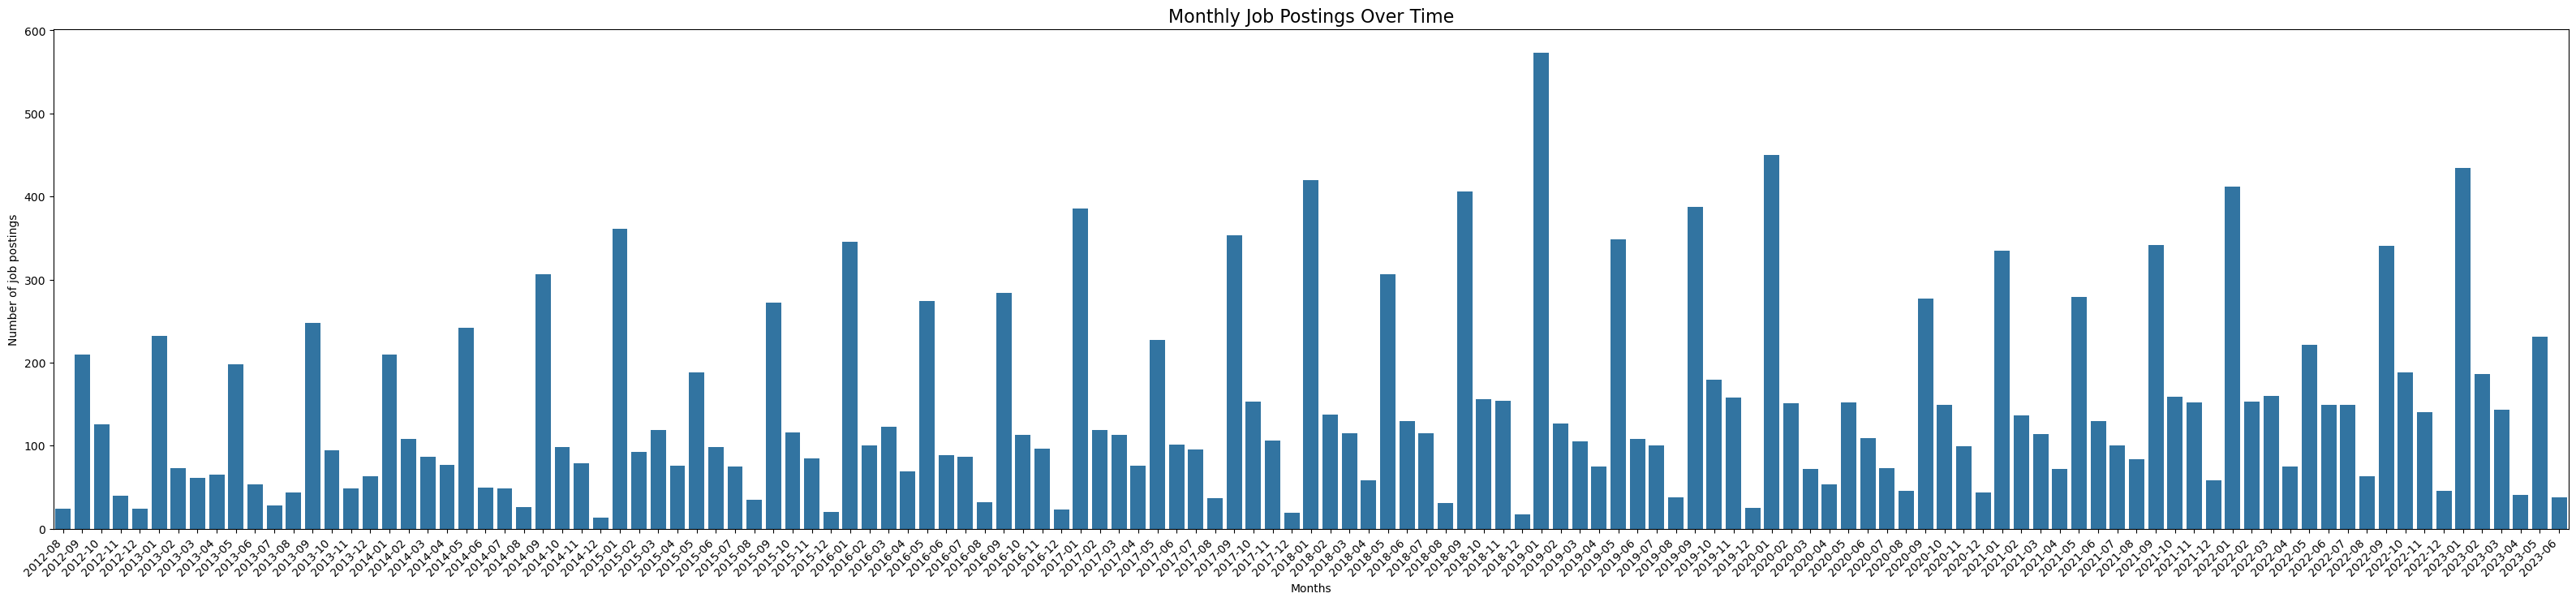

In [33]:
# Adjust the figure size directly
plt.figure(figsize=(40, 8))  # Adjust width and height as needed

# Use sns.barplot instead of sns.histplot for a bar chart
ax = sns.barplot(x="year_month", y="count", data=df_year_month)

# Set labels and adjust tick labels
ax.set(
    xlabel="Months", ylabel="Number of job postings"
)

# Set title
ax.set_title("Monthly Job Postings Over Time", fontsize=16)

# Set tick positions and labels
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Save the figure and display the plot
ax.figure.savefig(
    "reports/figures/coop_monthly_postings.png", bbox_inches="tight", dpi=300
)

plt.show()

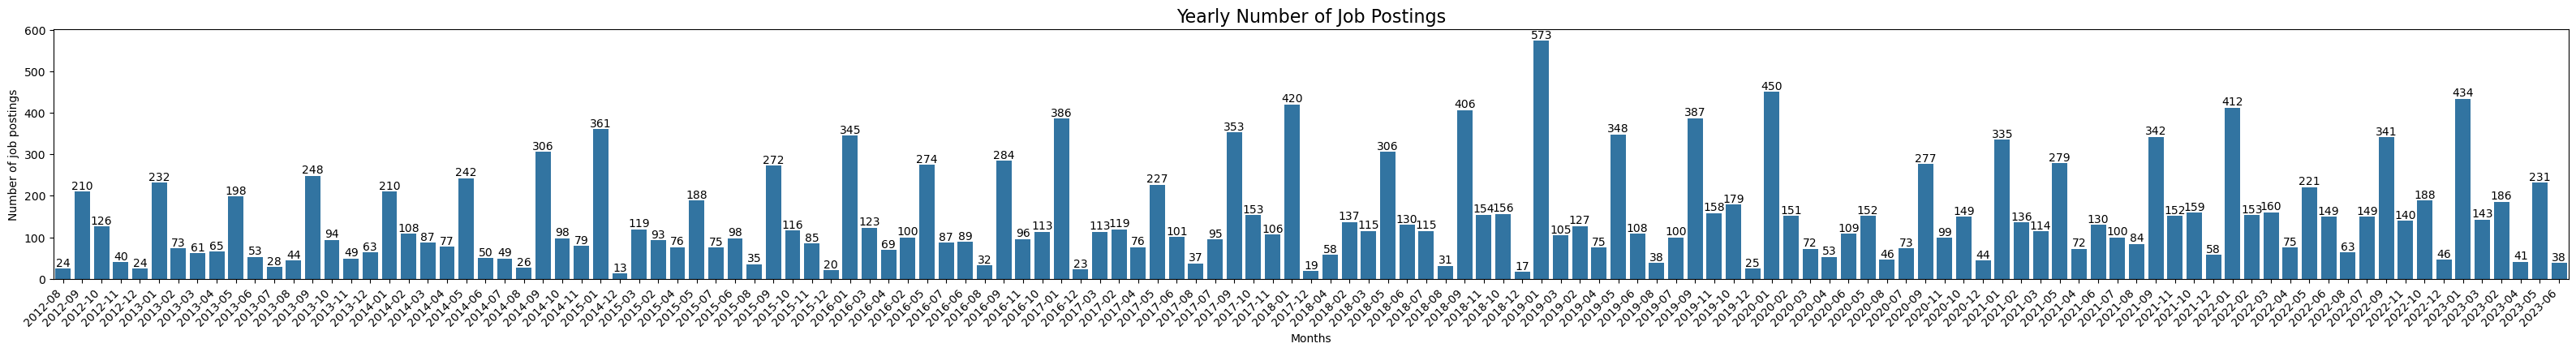

In [34]:
# Ensure df_explo["year_month"] is in the correct format (e.g., datetime)
df_explo["year_month"] = df_explo["date_goes_live"].dt.to_period("M")

# Adjust the figure size directly
plt.figure(figsize=(40, 4))

# Use sns.countplot for counting occurrences of each year_month
ax = sns.countplot(x="year_month", data=df_explo)

# Set title
ax.set_title("Yearly Number of Job Postings", fontsize=16)

# Set labels, tick positions, and adjust tick labels
ax.set(xlabel="Months", ylabel="Number of job postings")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Add count labels on top of the bars
ax.bar_label(ax.containers[0])

# Save the figure and display the plot
ax.figure.savefig(
    "reports/figures/coop_yearly_postings.png", bbox_inches="tight", dpi=300
)

plt.show()

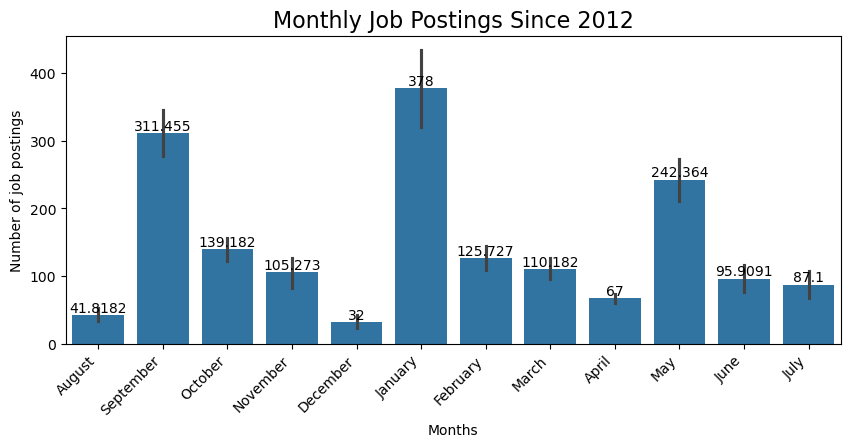

In [35]:
# Ensure df_explo["date_goes_live"] is in the correct format (e.g., datetime)
df_explo["date_goes_live"] = pd.to_datetime(df_explo["date_goes_live"])

# Define the order of months since 2012
start_date = "2012-01-01"
end_date = "2022-12-01"
months_in_order = pd.date_range(start=start_date, end=end_date, freq="MS")
months_in_order = months_in_order.map(lambda x: x.strftime("%B"))

# Create a DataFrame with months as a categorical variable and
# count job postings per month
df_month_sum = df_explo.groupby(
    df_explo["date_goes_live"].dt.to_period("M")
).size().reset_index(name="count")
df_month_sum["month"] = df_month_sum["date_goes_live"].dt.strftime("%B")

# Adjust the figure size directly
plt.figure(figsize=(10, 4))

# Use sns.barplot to plot the sum of job postings per month
ax = sns.barplot(x="month", y="count", data=df_month_sum)

# Set title
ax.set_title("Monthly Job Postings Since 2012", fontsize=16)

# Set labels, tick positions, and adjust tick labels
ax.set(xlabel="Months", ylabel="Number of job postings")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Add count labels on top of the bars
ax.bar_label(ax.containers[0])

# Save the figure and display the plot
plt.savefig(
    "reports/figures/coop_joined_monthly_postings_since_2012.png",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

In [36]:
# Ensure df_explo["date_goes_live"] is in the correct format (e.g., datetime)
df_explo["date_goes_live"] = pd.to_datetime(df_explo["date_goes_live"])

# Extract year and month from the date
df_explo["year"] = df_explo["date_goes_live"].dt.year
df_explo["month"] = df_explo["date_goes_live"].dt.month

# Group by year and month, summing up the counts
df_month_sum = df_explo.groupby(["year", "month"]).size().reset_index(name="count")

# Combine year and month columns into a single date column
df_month_sum["date"] = pd.to_datetime(df_month_sum[['year', 'month']].assign(DAY=1))

# Sort by date
df_month_sum.sort_values("date", inplace=True)

# Create subplot with Plotly
fig = make_subplots(rows=1, cols=1)

# Add candlestick trace to subplot
fig.add_trace(go.Candlestick(x=df_month_sum['date'],
                open=df_month_sum['count'],
                high=df_month_sum['count'] + df_month_sum['count'].std(),
                low=df_month_sum['count'] - df_month_sum['count'].std(),
                close=df_month_sum['count']))

# Update the layout for better visualization
fig.update_layout(
    title='Monthly Job Postings Variance Since 2012',
    xaxis_title='Date',
    yaxis_title='Number of Job Postings',
    xaxis_rangeslider_visible=True,
)

# Save the figure and display the plot in Jupyter Notebook
directory_path = "reports/figures/"
os.makedirs(directory_path, exist_ok=True)
file_path = os.path.join(directory_path, "coop_joined_monthly_postings_since_2012_candles.html")
pio.write_html(fig, file_path)
fig.show()

# Exploration of the Programs

In [37]:
print(
    df_coop_program_listed["job_description"][
        df_coop_program_listed["job_description"].duplicated()
    ].count()
)

1153


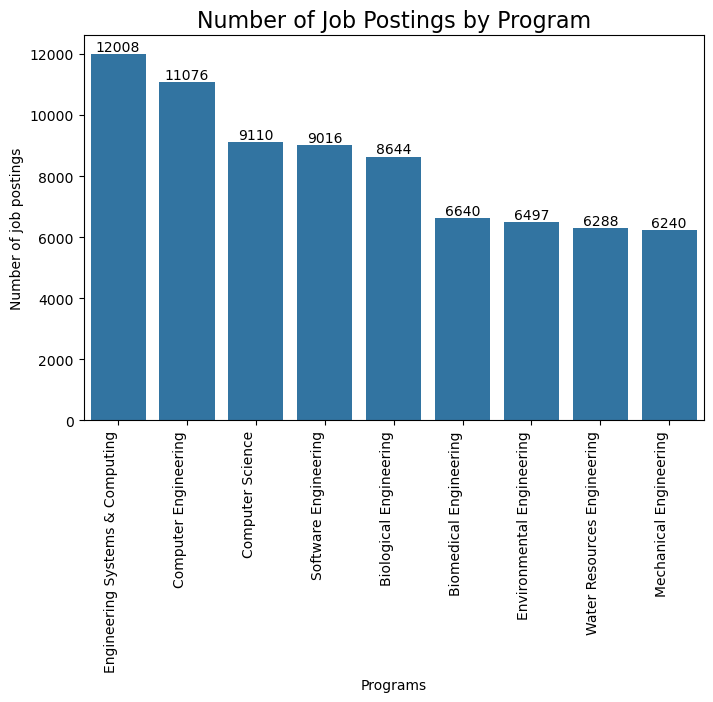

In [38]:
# Assuming program_name is a list in each row of df_explo
series_explo_program_name = df_explo["program_name"]\
    .apply(pd.Series)\
    .stack()\
    .reset_index(level=1, drop=True)

# Count the occurrences of each program_name
program_counts = series_explo_program_name.value_counts()

# Adjust the figure size directly
plt.figure(figsize=(8, 5))

# Use sns.barplot to display counts of each program_name
ax = sns.barplot(x=program_counts.index, y=program_counts.values, capsize=0.2)

# Set title
ax.set_title("Number of Job Postings by Program", fontsize=16)

# Set labels, tick positions, and adjust tick labels
ax.set(xlabel="Programs", ylabel="Number of job postings")
ax.set_xticks(range(len(program_counts)))  # Set explicit tick positions
ax.set_xticklabels(program_counts.index, rotation=90, ha="right")

# Add count labels on top of the bars
ax.bar_label(ax.containers[0])

# Save the figure and display the plot
plt.savefig("reports/figures/coop_postings_programs.png", bbox_inches="tight", dpi=300)
plt.show()

In [39]:
# Assuming df_explo['program_name'] is a list in each row
df_explo_exploded = df_explo.explode("program_name")

In [40]:
counts = pd.DataFrame(df_explo_exploded['program_name'].value_counts()).reset_index()
counts.columns = ['Program Name', 'Job Postings Count']

In [41]:
counts.to_csv('reports/program_name_count.csv', index=False)

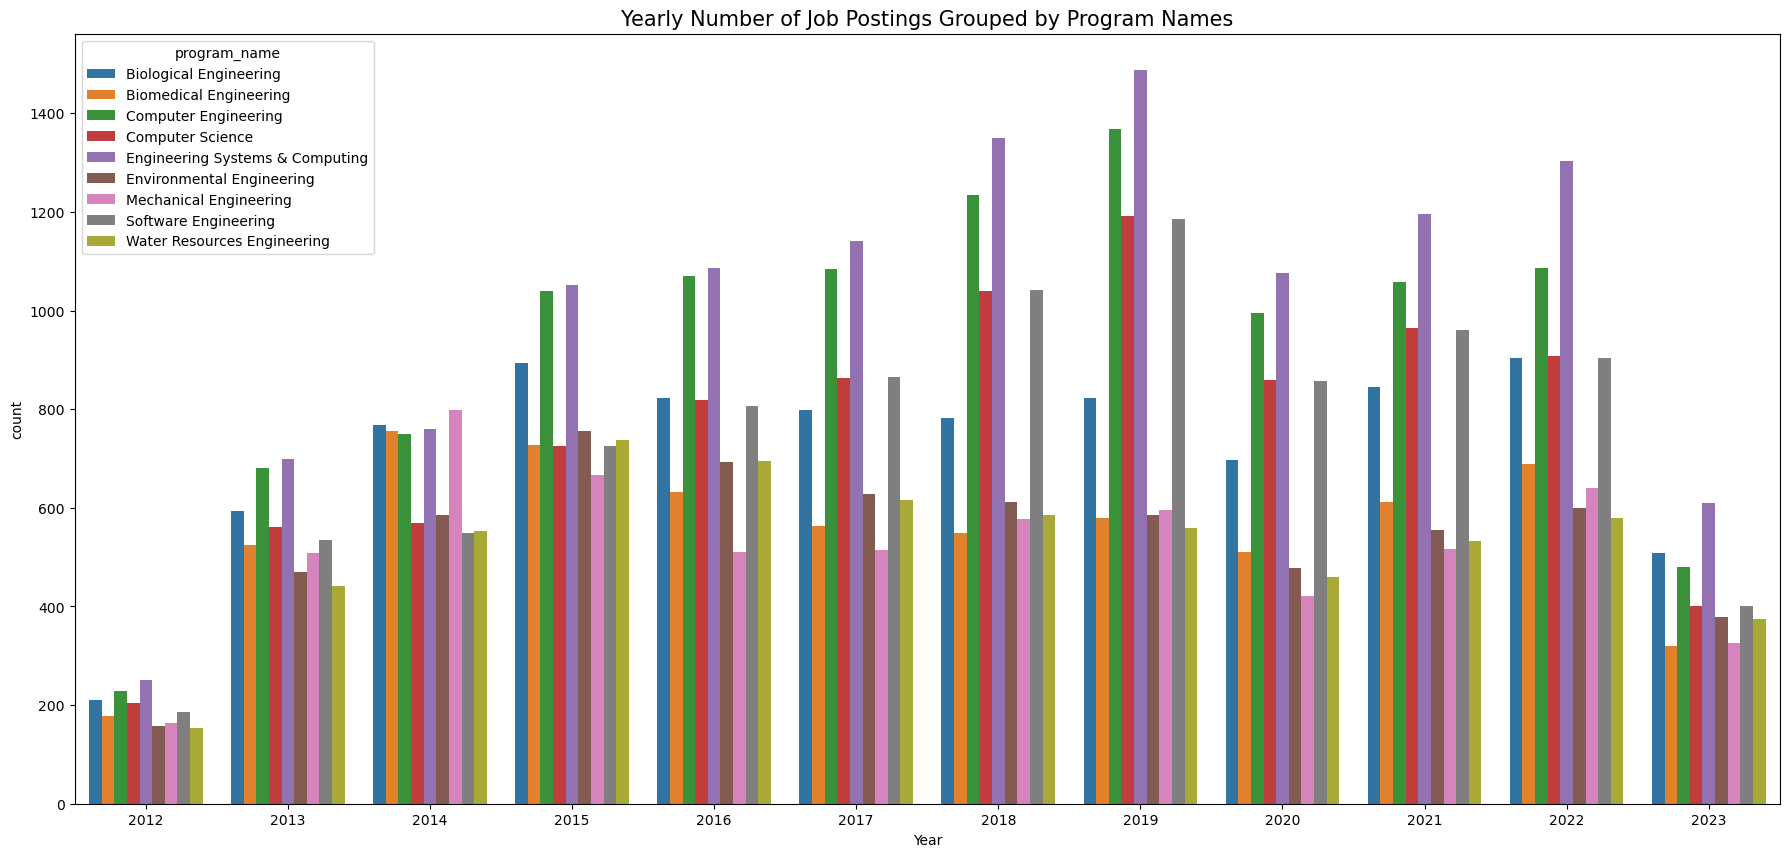

In [42]:
# Group by year and program_name and count the occurrences
s = (
    df_explo_exploded.groupby(
        [df_explo_exploded["date_goes_live"].dt.year, "program_name"]
    ).size().reset_index(name="count")
)

# Set the figure size
plt.figure(figsize=(22, 10))

# Use sns.barplot to display counts of each program_name
ax = sns.barplot(x="date_goes_live", y="count", data=s, hue="program_name")

# Set title and labels
ax.set_title(
    "Yearly Number of Job Postings Grouped by Program Names",
    fontdict={"size": 15}
)
ax.set_xlabel("Year")

# Save the figure and display the plot
plt.savefig(
    "reports/figures/coop_yearly_postings_group_programs.png",
    bbox_inches="tight",
    dpi=300,
)
plt.show()